#Stacked Regressions to predict House Prices 


##Serigne

**July 2017**

**If you use parts of this notebook in your scripts/notebooks, giving  some kind of credit would be very much appreciated :)  You can for instance link back to this notebook. Thanks!**

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

## Imports

In [3412]:
%pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user
%pip install opendatasets pandas numpy scikit-learn xgboost lightgbm tabulate category_encoders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3413]:
#import some necessary librairies
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["dir", "C:/Users/anirb/aiml/UT-Austin-PGP/input/"]).decode("utf8")) #check the files available in the directory

## Dataload

In [3414]:
#Now let's import and put the train and test datasets in  pandas dataframe
folderPath = 'C:/Users/anirb/aiml/UT-Austin-PGP'
train = pd.read_csv(folderPath + '/input/train.csv')
test = pd.read_csv(folderPath + '/input/test.csv')


In [3415]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Registration Number']
test_ID = test['Registration Number']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Registration Number", axis = 1, inplace = True)
test.drop("Registration Number", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (3493, 34) 
The test data size before dropping Id feature is : (500, 33) 

The train data size after dropping Id feature is : (3493, 33) 
The test data size after dropping Id feature is : (500, 32) 


## Data Processing

## Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


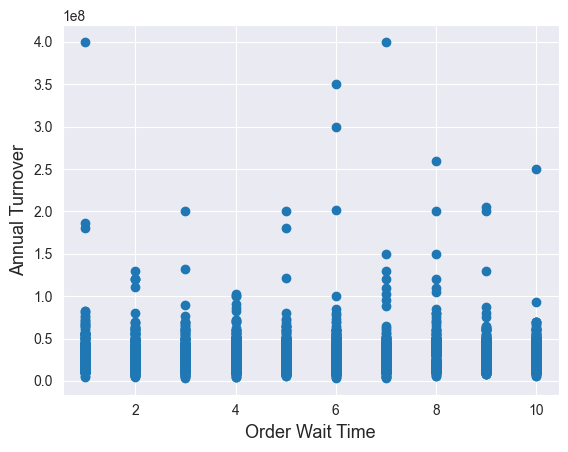

In [3416]:

fig, ax = plt.subplots()
ax.scatter(x = train['Order Wait Time'], y = train['Annual Turnover'])
plt.ylabel('Annual Turnover', fontsize=13)
plt.xlabel('Order Wait Time', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

### Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

## Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 30725708.56 and sigma = 21648147.45



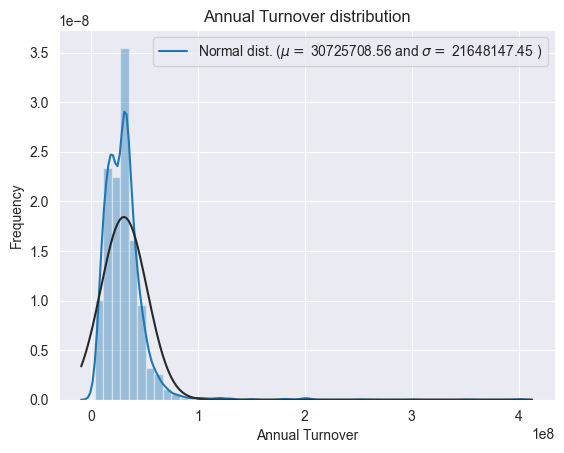

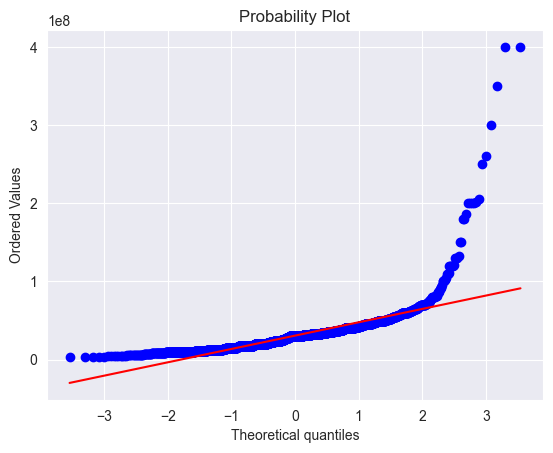

In [3417]:
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

#### **Log-transformation of the target variable**


 mu = 17.09 and sigma = 0.55



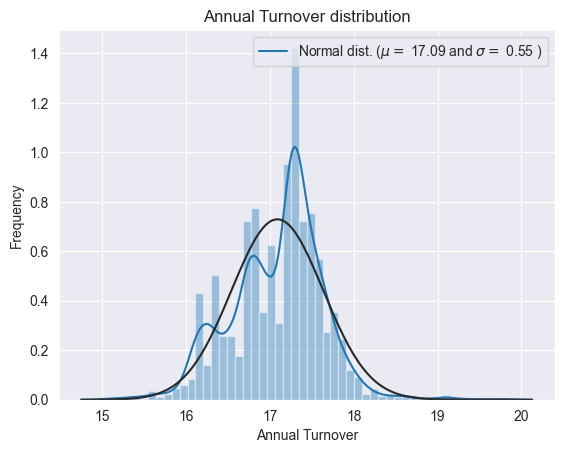

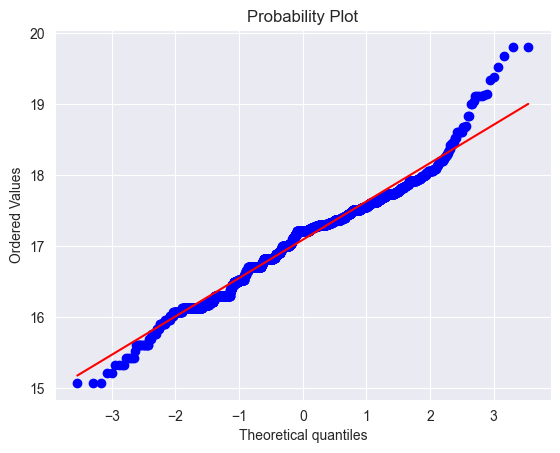

In [3418]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["Annual Turnover"] = np.log1p(train["Annual Turnover"])

#Check the new distribution 
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()


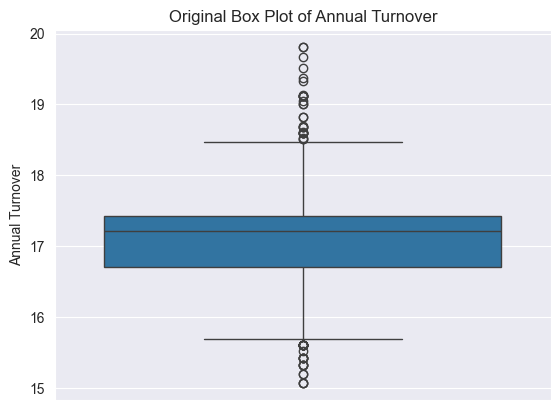

In [3419]:
sns.boxplot(train['Annual Turnover'])
plt.title(f'Original Box Plot of Annual Turnover')
plt.show()



### ZScore Removal

In [3420]:

from scipy import stats
import numpy as np
z = np.abs(stats.zscore(train['Annual Turnover']))
print(z)

import numpy as np

threshold_z = 2

outlier_indices = np.where(z > threshold_z)[0]
print("Original DataFrame Shape:", train.shape)
train = train.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", train.shape)


0      0.851
1      1.169
2      0.382
3      2.611
4      0.506
        ... 
3488   0.784
3489   0.382
3490   0.872
3491   1.276
3492   1.440
Name: Annual Turnover, Length: 3493, dtype: float64
Original DataFrame Shape: (3493, 33)
DataFrame Shape after Removing Outliers: (3374, 33)


In [3421]:
# Q1 = train['Annual Turnover'].quantile(0.18)
# Q3 = train['Annual Turnover'].quantile(0.80)
# IQR = Q3 - Q1
# lower = Q1 - IQR
# upper = Q3 + IQR
 
# # Create arrays of Boolean values indicating the outlier rows
# upper_array = np.where(train['Annual Turnover'] >= upper)[0]
# lower_array = np.where(train['Annual Turnover'] <= lower)[0]
 
# # Removing the outliers
# train.drop(index=upper_array, inplace=True)
# train.drop(index=lower_array, inplace=True)
 
# # Print the new shape of the DataFrame
# print("New Shape: ", train.shape)

### IQR Removal

In [3422]:
# Q1 = train['Annual Turnover'].quantile(0.25)
# Q3 = train['Annual Turnover'].quantile(0.75)
# IQR = Q3 - Q1
# lower = Q1 - 1.5*IQR
# upper = Q3 + 1.5*IQR
 
# # Create arrays of Boolean values indicating the outlier rows
# upper_array = np.where(train['Annual Turnover'] >= upper)[0]
# lower_array = np.where(train['Annual Turnover'] <= lower)[0]
 
# # Removing the outliers
# train = train.drop(index=upper_array)
# train = train.drop(index=lower_array)
 
# # Print the new shape of the DataFrame
# print("New Shape: ", train.shape)

The skew seems now corrected and the data appears more normally distributed. 

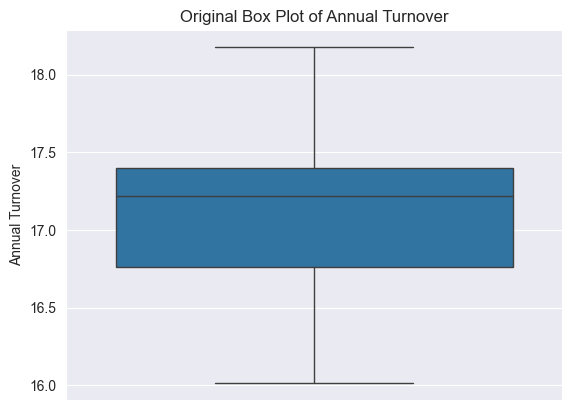

In [3423]:
sns.boxplot(train['Annual Turnover'])
plt.title(f'Original Box Plot of Annual Turnover')
plt.show()




 mu = 17.09 and sigma = 0.48



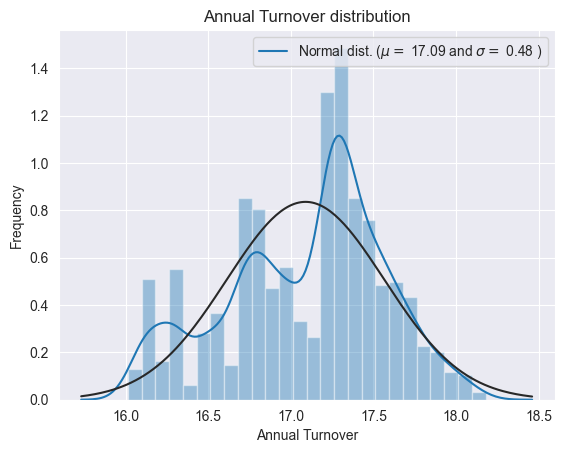

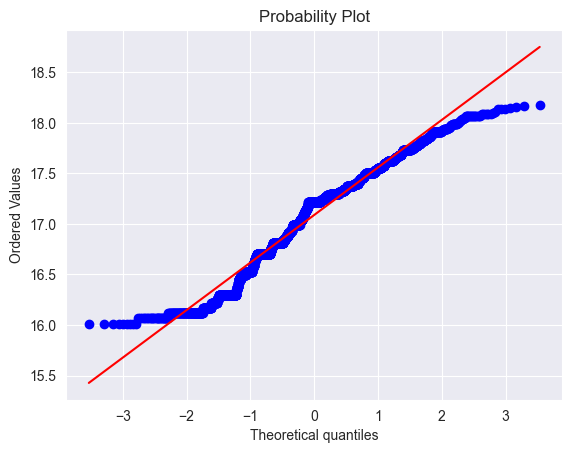

In [3424]:
#Check the new distribution 
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()

## Features engineering

#### Train and Test Data Merge

In [3425]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['Annual Turnover'].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Annual Turnover'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (3874, 32)


#### Correlation

<Axes: >

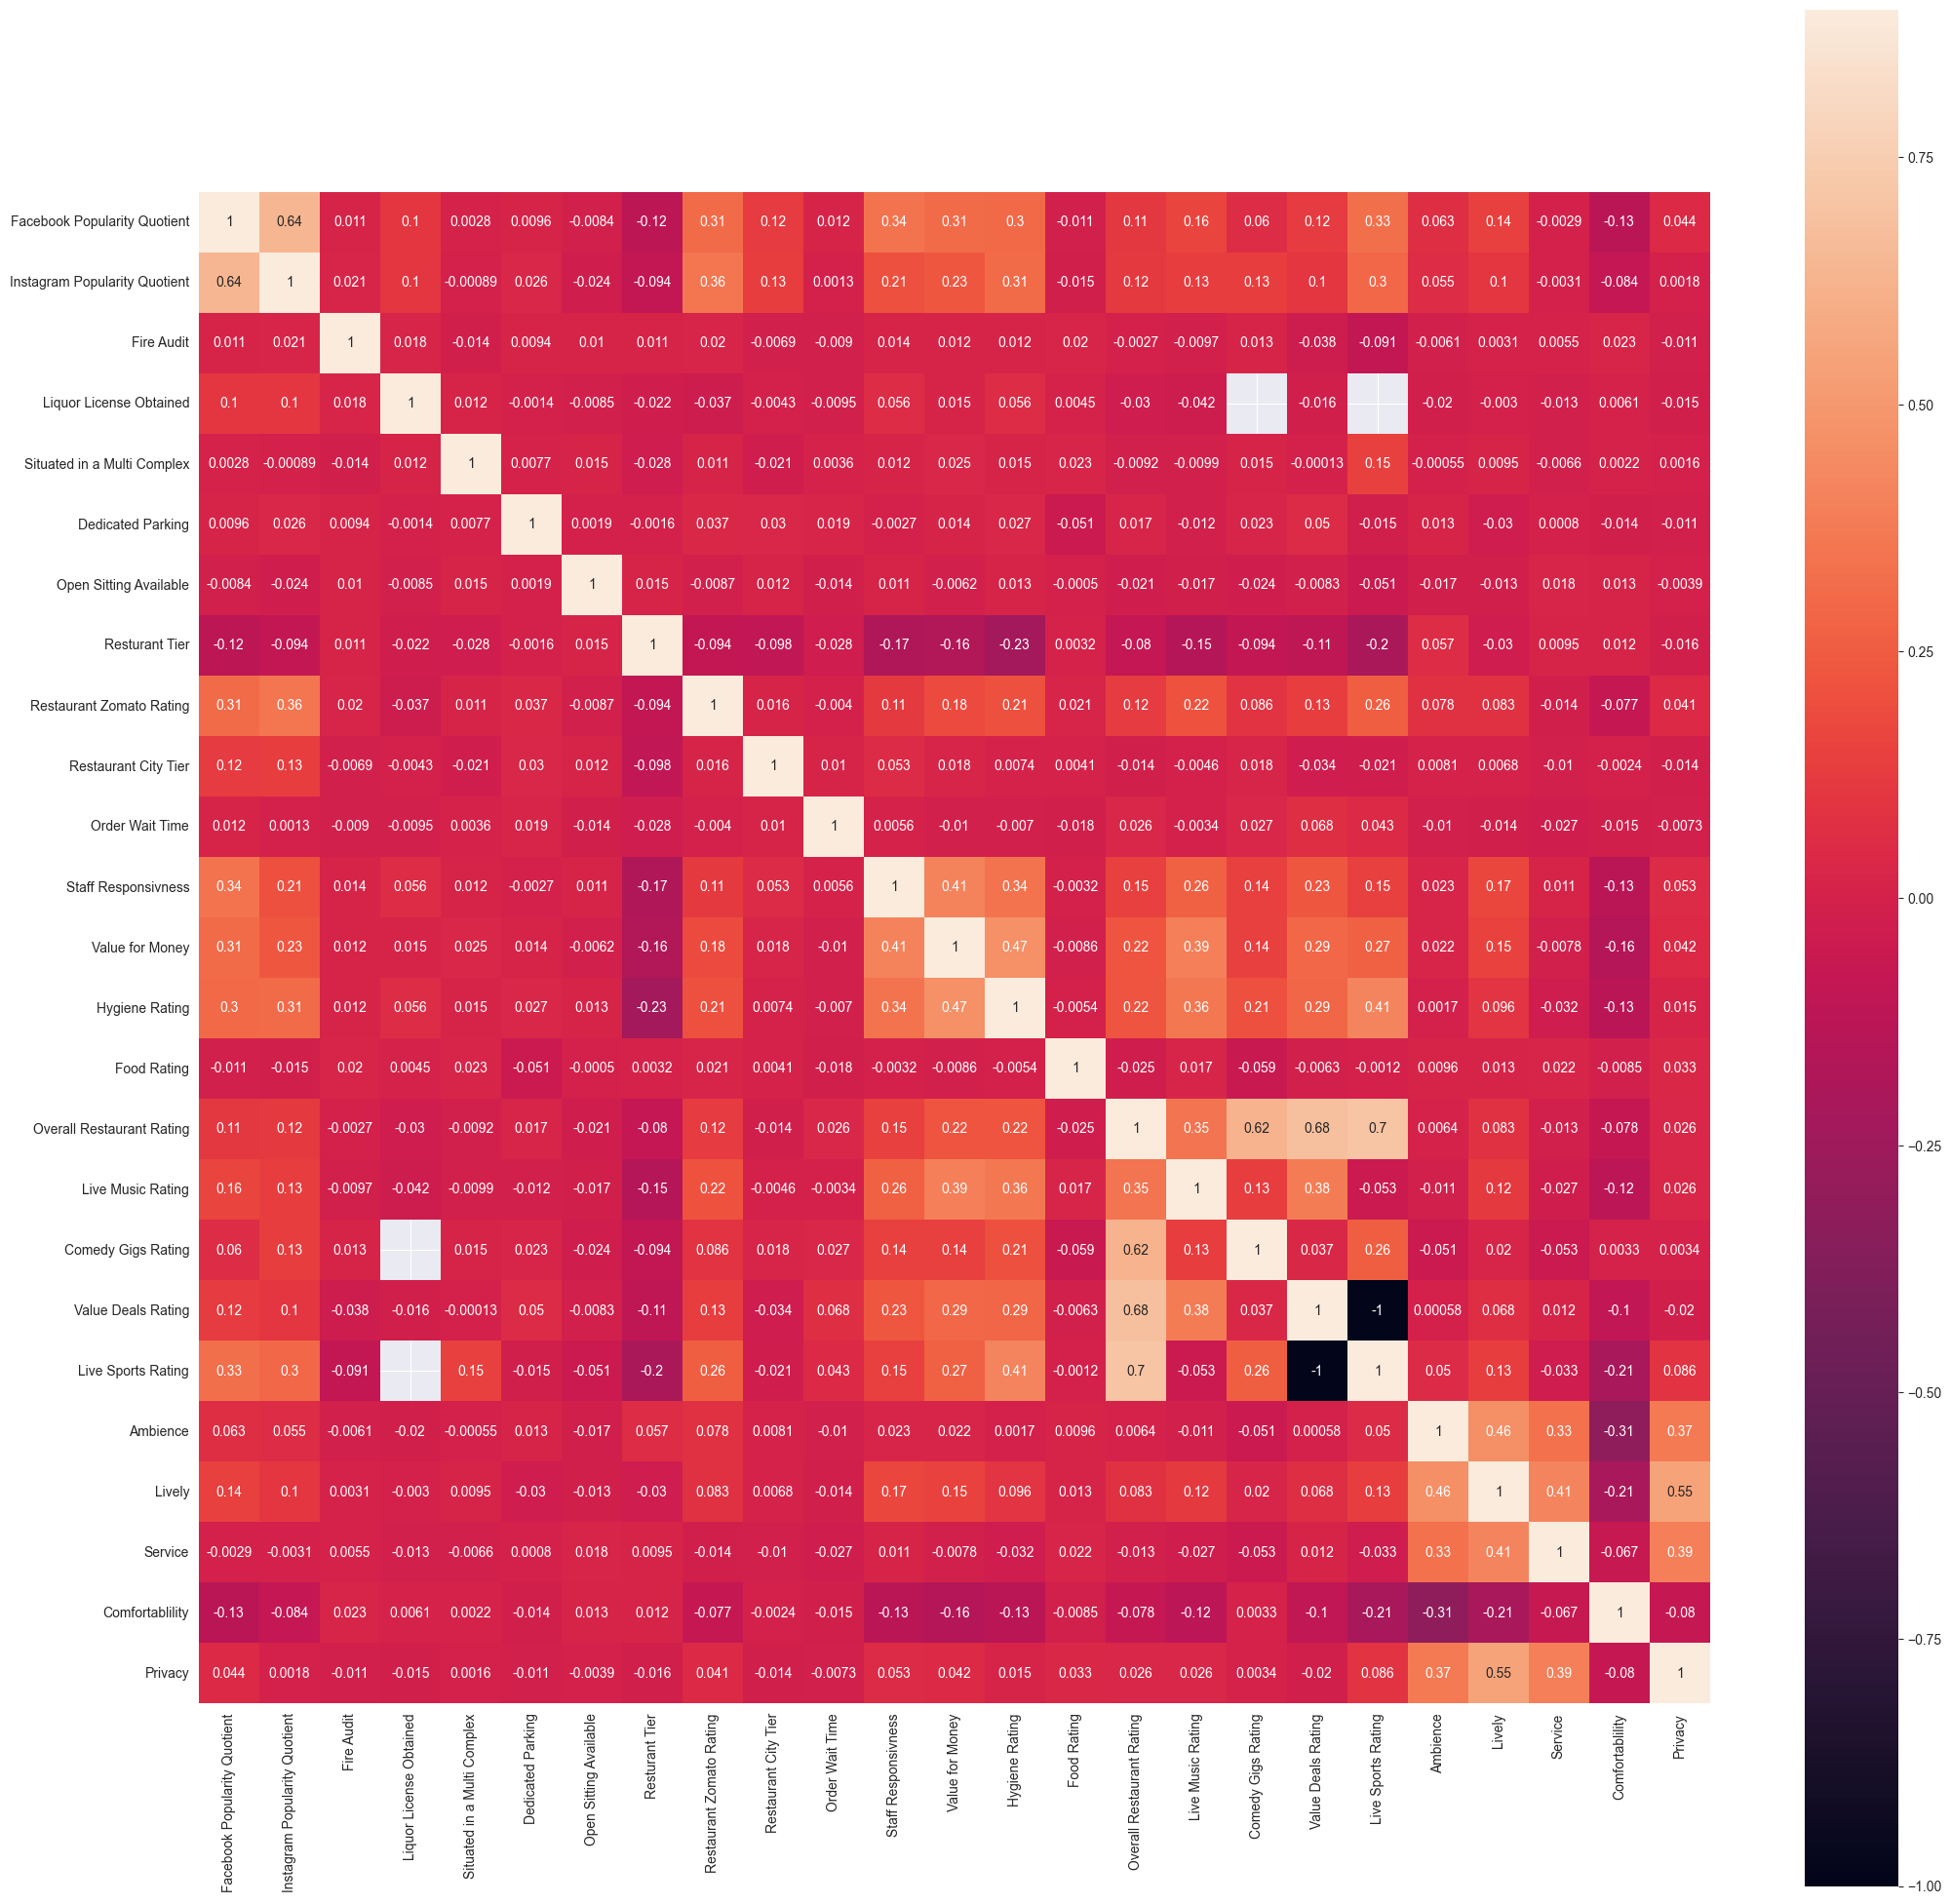

In [3426]:
#Correlation map to see how features are correlated with SalePrice
# choose cols that only contains number
numeric_cols = all_data.select_dtypes(include='number')

# then use this new col to do the next step
corrmat = numeric_cols.corr()

plt.subplots(figsize=(25,25))  #this step is very important, without it you will miss many figure.
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

### Fix City

In [3427]:
# all_data['City'] = all_data['City'].replace('-1', 'OTHER')
all_data['City'] = all_data['City'].str.upper().str.strip()

In [3428]:
# replacement_pattern = r"^(BANGALORE|BANGLORE|BENGALURU|Asifabadbanglore|Banaglore)$"  # Consider using raw string for regex

# Replace matching values with 'BANGALORE' (case-sensitive)
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BANGALORE')


replacement_pattern = r"^(BHUBANESHWAR|BHUBANESWAR|BHUBNESHWAR)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BHUBANESHWAR')


replacement_pattern = r"^(TRIVANDRUM|THIRUVANANTHAPURAM|THIRUVANANTHAPURAM)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'TRIVANDRUM')

replacement_pattern = r"^(GURAGAON|GURGAON)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'GURAGAON')

replacement_pattern = r"^(NEW DEHLI|NEW DELHI)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'NEW DELHI')


replacement_pattern = r"^(VISAKHAPATNAM|VIZAG|VSAKHAPTTNAM)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'VIZAG')

# all_data.loc[all_data['City'].isin((all_data['City'].value_counts()[all_data['City'].value_counts() < 6]).index), 'City'] = 'OTHER'

all_data['City'].value_counts().sort_values(ascending=False)



BANGALORE     657
-1            449
NOIDA         377
HYDERABAD     363
PUNE          321
             ... 
DAMMAM          1
BARIPADA        1
BANAGLORE       1
ROURKELA        1
SHAHIBABAD      1
Name: City, Length: 209, dtype: int64

### Missing Data

In [3429]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Live Sports Rating,94.244
Value Deals Rating,77.439
Comedy Gigs Rating,71.399
Live Music Rating,21.864
Overall Restaurant Rating,6.195
Facebook Popularity Quotient,2.426
Instagram Popularity Quotient,1.446
Resturant Tier,1.239
Ambience,0.645


Text(0.5, 1.0, 'Percent missing data by feature')

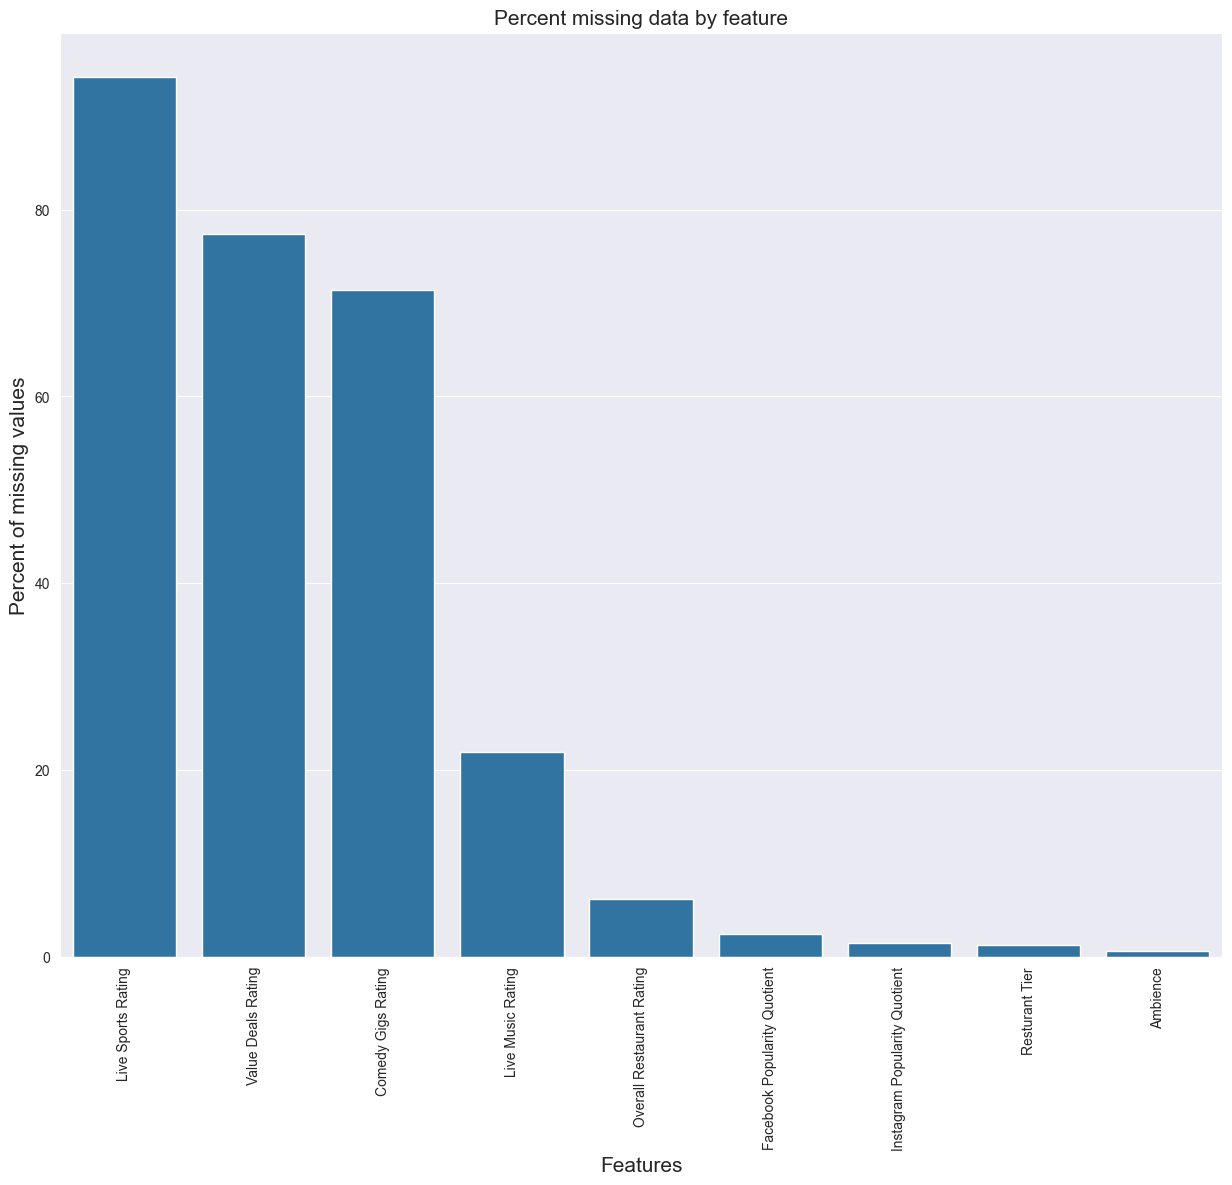

In [3430]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


<Axes: >

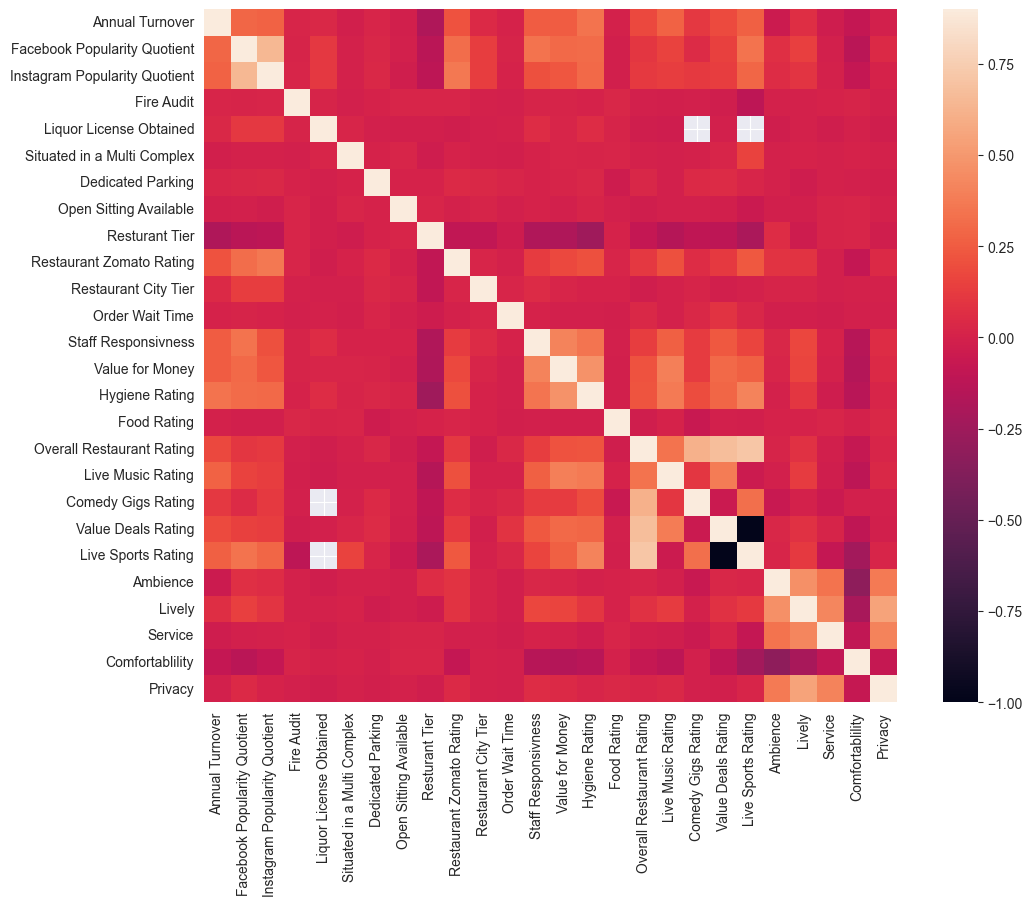

In [3431]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,color='blue')

#### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

Live Sports Rating	94.140
Value Deals Rating	77.436
Comedy Gigs Rating	71.450
Live Music Rating	21.713
Overall Restaurant Rating	6.161
Facebook Popularity Quotient	2.479
Instagram Popularity Quotient	1.402
Resturant Tier	1.227
Ambience	0.626

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [3432]:
all_data["Live Sports Rating"] = all_data["Live Sports Rating"].transform(lambda x: x.fillna(x.median()))
all_data["Live Sports Rating"].value_counts(dropna=False)

4.000    3738
3.000      84
5.000      27
2.000      20
6.000       5
Name: Live Sports Rating, dtype: int64

- **MiscFeature** : data description says NA means "no misc feature"


In [3433]:
all_data["Value Deals Rating"] = all_data["Value Deals Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Value Deals Rating'].value_counts(dropna=False)


4.000    3308
3.000     307
5.000     141
2.000      92
6.000      20
1.000       4
7.000       2
Name: Value Deals Rating, dtype: int64

In [3434]:
all_data["Comedy Gigs Rating"] = all_data["Comedy Gigs Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Comedy Gigs Rating'].value_counts(dropna=False)


3.000    3269
2.000     310
4.000     214
5.000      46
1.000      33
6.000       2
Name: Comedy Gigs Rating, dtype: int64

- **Alley** : data description says NA means "no alley access"

In [3435]:
all_data["Live Music Rating"] = all_data["Live Music Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Live Music Rating'].value_counts(dropna=False)


4.000    2093
3.000     753
5.000     699
6.000     174
2.000     109
1.000      29
7.000      15
8.000       2
Name: Live Music Rating, dtype: int64

In [3436]:
all_data["Overall Restaurant Rating"] = all_data["Overall Restaurant Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Overall Restaurant Rating'].value_counts(dropna=False)


9.000     1377
10.000     944
7.000      644
8.000      580
6.000      329
Name: Overall Restaurant Rating, dtype: int64

In [3437]:
all_data["Facebook Popularity Quotient"] = all_data["Facebook Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Facebook Popularity Quotient'].value_counts(dropna=False)


77.938    94
82.000    67
78.000    67
76.000    64
73.000    63
          ..
92.100     1
63.660     1
90.010     1
82.560     1
78.280     1
Name: Facebook Popularity Quotient, Length: 822, dtype: int64

In [3438]:
all_data["Instagram Popularity Quotient"] = all_data["Instagram Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Instagram Popularity Quotient'].value_counts(dropna=False)

70.000    67
72.000    64
74.000    60
68.000    56
74.496    56
          ..
55.550     1
65.900     1
76.770     1
68.150     1
53.550     1
Name: Instagram Popularity Quotient, Length: 784, dtype: int64

- **Fence** : data description says NA means "no fence"

In [3439]:
all_data["Ambience"] = all_data["Ambience"].transform(lambda x: x.fillna(x.median()))
all_data['Ambience'].value_counts(dropna=False)


6.000     760
8.000     738
7.000     686
5.000     416
9.000     390
4.000     386
10.000    179
3.000     162
2.000      99
1.000      32
0.000      26
Name: Ambience, dtype: int64

In [3440]:
all_data["Resturant Tier"] = all_data["Resturant Tier"].transform(lambda x: x.fillna(x.median()))
all_data['Resturant Tier'].value_counts(dropna=False)


2.000    3603
1.000     271
Name: Resturant Tier, dtype: int64

- **FireplaceQu** : data description says NA means "no fireplace"

Is there any remaining missing value ? 

In [3441]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [3442]:
# #MSSubClass=The building class
# all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


# #Changing OverallCond into a categorical variable
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)


# #Year and month sold are transformed into categorical features.
# all_data['YrSold'] = all_data['YrSold'].astype(str)
# all_data['MoSold'] = all_data['MoSold'].astype(str)



#### Label Encoding some categorical variables that may contain information in their ordering set** 

In [3443]:
all_data.dtypes

Cuisine                           object
City                              object
Restaurant Location               object
Opening Day of Restaurant         object
Facebook Popularity Quotient     float64
Endorsed By                       object
Instagram Popularity Quotient    float64
Fire Audit                         int64
Liquor License Obtained            int64
Situated in a Multi Complex        int64
Dedicated Parking                  int64
Open Sitting Available             int64
Resturant Tier                   float64
Restaurant Type                   object
Restaurant Theme                  object
Restaurant Zomato Rating           int64
Restaurant City Tier               int64
Order Wait Time                    int64
Staff Responsivness                int64
Value for Money                    int64
Hygiene Rating                     int64
Food Rating                        int64
Overall Restaurant Rating        float64
Live Music Rating                float64
Comedy Gigs Rati

#### Ordinal Encoding

In [3444]:
# 		Situated in a Multi Complex	Dedicated Parking	Open Sitting Available	
    
# ordinal_mappings = {
#     "Fire Audit": [0,1], 
#     "Liquor License Obtained": [np.nan,'Fa','TA','Gd','Ex'], 
#     "LotShape": [np.nan,'Reg','IR1' ,'IR2','IR3'], 
#     "BsmtQual": [np.nan,'Fa','TA','Gd','Ex'], 
#     "BsmtCond": [np.nan,'Po','Fa','TA','Gd','Ex'], 
#     "BsmtExposure": [np.nan,'No','Mn','Av','Gd'], 
#     "BsmtFinType1": [np.nan,'Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ], 
#     "BsmtFinType2": [np.nan,'Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ], 
#     "HeatingQC": [np.nan,'Po','Fa','TA','Gd','Ex'], 
#     "Functional": [np.nan,'Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], 
#     "FireplaceQu": [np.nan,'Po','Fa','TA','Gd','Ex'], 
#     "KitchenQual": [np.nan,'Fa','TA','Gd','Ex'], 
#     "GarageFinish": [np.nan,'Unf','RFn','Fin'], 
#     "GarageQual": [np.nan,'Po','Fa','TA','Gd','Ex'], 
#     "GarageCond": [np.nan,'Po','Fa','TA','Gd','Ex'], 
#     "PoolQC": [np.nan,'Fa','Gd','Ex'], 
#     "Fence": [np.nan,'MnWw','GdWo','MnPrv','GdPrv'],
# }

# # transform to a suitable format for ce.OrdinalEncoder
# ce_ordinal_mappings = []
# for col, unique_values in ordinal_mappings.items():
#     local_mapping = {val:idx for idx, val in enumerate(unique_values)}
#     ce_ordinal_mappings.append({"col":col, "mapping":local_mapping})

# encoder = ce.OrdinalEncoder(mapping=ce_ordinal_mappings, return_df=True)
# encoder.fit_transform(train_X)
# encoder.transform(test)

In [3445]:
# from sklearn.preprocessing import LabelEncoder

# cols = (
#     "Fire Audit",
#     "Liquor License Obtained",
#     "Situated in a Multi Complex",
#     "Dedicated Parking",
#     "Open Sitting Available",
#     # "Resturant Tier",
#     # "Restaurant Zomato Rating",
#     # "Restaurant City Tier",
#     # "Order Wait Time",
#     # "Staff Responsivness",
#     # "Value for Money",
#     # "Hygiene Rating",
#     # "Food Rating",
#     # "Overall Restaurant Rating",
#     # "Live Music Rating",
#     # "Comedy Gigs Rating",
#     # "Value Deals Rating",
#     # "Live Sports Rating",
#     # "Ambience",
#     # "Lively",
#     # "Service",
#     # "Comfortablility",
#     # "Privacy",
# )
# # process columns, apply LabelEncoder to categorical features
# for c in cols:
#     lbl = LabelEncoder()
#     lbl.fit(list(all_data[c].values))
#     all_data[c] = lbl.transform(list(all_data[c].values))

# # shape
# print("Shape all_data: {}".format(all_data.shape))

# all_data


#### Skewed features**

In [3446]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
Restaurant City Tier,0.866
Comedy Gigs Rating,0.259
Comfortablility,0.254
Staff Responsivness,0.177
Restaurant Zomato Rating,0.051
Live Music Rating,0.044
Food Rating,-0.006
Order Wait Time,-0.013
Instagram Popularity Quotient,-0.028
Hygiene Rating,-0.030


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [3447]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 25 skewed numerical features to Box Cox transform


In [3448]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
Restaurant City Tier,0.866
Food Rating,-0.287
Instagram Popularity Quotient,-0.413
Staff Responsivness,-0.523
Overall Restaurant Rating,-0.776
Value for Money,-0.870
Order Wait Time,-0.894
Facebook Popularity Quotient,-0.987
Hygiene Rating,-1.075
Fire Audit,-1.431


**Getting dummy categorical features**

#### City Treatment

##### TE

In [3449]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])

# #train = all_data[:ntrain]
# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['City_TE'] = encoder.fit_transform(train['City'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['City_TE', 'City']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# city_target_means = df_target_encoding.set_index('City')['City_TE'].to_dict()
# print(city_target_means)

# # # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]

# test['City_TE'] = test['City'].replace(city_target_means)
# # # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)
# #all_data.drop(['City'], axis=1, inplace=True)

# #test
# all_data

# # print(train['City_TE'])
# # df_test.head()



##### Tier Treatment

In [3450]:
all_data

,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,Liquor License Obtained,Situated in a Multi Complex,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,"indian,irish",BANGALORE,Near Business Hub,14-02-2009,1.991,Not Specific,2.024,0.548,0.548,0.548,...,1.357,1.037,0.933,1.037,1.037,1.282,1.282,1.182,1.182,1.182
1,"indian,irish",INDORE,Near Party Hub,29-09-2008,1.994,Tier A Celebrity,1.993,0.548,0.548,0.548,...,1.322,1.037,1.037,1.037,1.037,1.117,1.236,1.236,0.933,1.282
2,"tibetan,italian",CHENNAI,Near Business Hub,30-07-2011,1.993,Tier A Celebrity,1.934,0.548,0.548,0.548,...,1.282,0.933,0.933,1.037,1.037,1.236,1.357,1.117,0.786,1.282
3,"irish,belgian",MANESAR,Near Party Hub,22-02-2010,1.970,Tier A Celebrity,1.966,0.548,0.548,0.548,...,1.182,1.037,0.786,1.037,1.037,1.236,1.182,0.786,1.037,1.182
4,"tibetan,greek",HYDERABAD,Near Party Hub,28-06-2011,2.008,Not Specific,1.999,0.548,0.548,0.548,...,1.322,1.182,0.933,1.037,1.037,1.182,1.117,0.000,0.786,1.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,"indian,irish",NOIDA,Near Party Hub,08-09-2009,1.949,Not Specific,1.949,0.548,0.548,0.548,...,1.322,1.117,0.933,1.037,1.037,1.236,1.282,1.117,0.786,1.236
3870,"tibetan,greek",BANGALORE,Near Party Hub,20-06-2007,1.971,Not Specific,1.869,0.548,0.548,0.548,...,1.282,0.933,0.933,1.037,1.037,1.322,1.282,1.282,1.037,1.282
3871,"indian,irish",BANGALORE,Near Party Hub,19-06-2010,1.951,Tier A Celebrity,1.947,0.000,0.548,0.000,...,1.322,1.117,0.933,1.037,1.037,0.548,1.182,1.117,1.236,0.786
3872,"tibetan,greek",CHENNAI,Near Party Hub,23-08-2012,2.018,Not Specific,2.025,0.548,0.548,0.000,...,1.322,1.182,1.182,1.037,1.037,1.236,1.236,0.786,0.933,1.117


In [3451]:
# # Function to assign tier based on frequency (uses city_counts for lookup)
# def assign_tier(city, city_counts):
#   if city == '-1':
#     return 'Unknown City Tier'
#   count = city_counts.get(city)  # Lookup count for the current city
#   if count is None:
#     count = 0  # Handle cities not present in city_counts (assign Tier3)
#   total_rows = len(city_counts)
#   tier_1_pct = 0.5  # Top 50% of rows are Tier 1 (most frequent)
#   tier_2_pct = 0.4  # Next 40% of rows are Tier 2
#   tier_3_threshold = total_rows * tier_2_pct  # Anything below is Tier 3 (least frequent)
#   if count >= total_rows * tier_1_pct:
#     return 'City_Tier1'
#   elif count >= tier_3_threshold:
#     return 'City_Tier2'
#   else:
#     return 'City_Tier3'

# # Count city occurrences and sort by descending frequency
# city_counts = all_data['City'].value_counts().sort_values(ascending=False)
# total_rows = len(all_data)  # Assuming this is the total number of rows in df

# # Add a new 'City Tier' column based on frequency lookup in city_counts
# all_data['City Tier'] = all_data['City'].apply(lambda city: assign_tier(city, city_counts.copy()))

# # Print the DataFrame with the new 'City Tier' column
# all_data['City Tier'].value_counts(dropna=False).sort_values(ascending=False)

##### Binary Encoding

In [3452]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['City'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Cuisine,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,Restaurant Location,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,"indian,irish",0,0,0,0,0,0,0,1,Near Business Hub,...,1.357,1.037,0.933,1.037,1.037,1.282,1.282,1.182,1.182,1.182
1,"indian,irish",0,0,0,0,0,0,1,0,Near Party Hub,...,1.322,1.037,1.037,1.037,1.037,1.117,1.236,1.236,0.933,1.282
2,"tibetan,italian",0,0,0,0,0,0,1,1,Near Business Hub,...,1.282,0.933,0.933,1.037,1.037,1.236,1.357,1.117,0.786,1.282
3,"irish,belgian",0,0,0,0,0,1,0,0,Near Party Hub,...,1.182,1.037,0.786,1.037,1.037,1.236,1.182,0.786,1.037,1.182
4,"tibetan,greek",0,0,0,0,0,1,0,1,Near Party Hub,...,1.322,1.182,0.933,1.037,1.037,1.182,1.117,0.000,0.786,1.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,"indian,irish",0,0,0,0,0,1,1,1,Near Party Hub,...,1.322,1.117,0.933,1.037,1.037,1.236,1.282,1.117,0.786,1.236
3870,"tibetan,greek",0,0,0,0,0,0,0,1,Near Party Hub,...,1.282,0.933,0.933,1.037,1.037,1.322,1.282,1.282,1.037,1.282
3871,"indian,irish",0,0,0,0,0,0,0,1,Near Party Hub,...,1.322,1.117,0.933,1.037,1.037,0.548,1.182,1.117,1.236,0.786
3872,"tibetan,greek",0,0,0,0,0,0,1,1,Near Party Hub,...,1.322,1.182,1.182,1.037,1.037,1.236,1.236,0.786,0.933,1.117


#### Restaurant Theme 

##### Target E

In [3453]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])

# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['Theme_TE'] = encoder.fit_transform(train['Restaurant Theme'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['Theme_TE', 'Restaurant Theme']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# theme_target_means = df_target_encoding.set_index('Restaurant Theme')['Theme_TE'].to_dict()
# # print(city_target_means)

# # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]
# test['Theme_TE'] = test['Restaurant Theme'].replace(theme_target_means)
# # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)

# #all_data.drop('Restaurant Theme', axis=1, inplace=True)

# all_data

##### Binary Encoding

In [3454]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['Restaurant Theme'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Cuisine,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,Restaurant Location,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,"indian,irish",0,0,0,0,0,0,0,1,Near Business Hub,...,1.357,1.037,0.933,1.037,1.037,1.282,1.282,1.182,1.182,1.182
1,"indian,irish",0,0,0,0,0,0,1,0,Near Party Hub,...,1.322,1.037,1.037,1.037,1.037,1.117,1.236,1.236,0.933,1.282
2,"tibetan,italian",0,0,0,0,0,0,1,1,Near Business Hub,...,1.282,0.933,0.933,1.037,1.037,1.236,1.357,1.117,0.786,1.282
3,"irish,belgian",0,0,0,0,0,1,0,0,Near Party Hub,...,1.182,1.037,0.786,1.037,1.037,1.236,1.182,0.786,1.037,1.182
4,"tibetan,greek",0,0,0,0,0,1,0,1,Near Party Hub,...,1.322,1.182,0.933,1.037,1.037,1.182,1.117,0.000,0.786,1.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,"indian,irish",0,0,0,0,0,1,1,1,Near Party Hub,...,1.322,1.117,0.933,1.037,1.037,1.236,1.282,1.117,0.786,1.236
3870,"tibetan,greek",0,0,0,0,0,0,0,1,Near Party Hub,...,1.282,0.933,0.933,1.037,1.037,1.322,1.282,1.282,1.037,1.282
3871,"indian,irish",0,0,0,0,0,0,0,1,Near Party Hub,...,1.322,1.117,0.933,1.037,1.037,0.548,1.182,1.117,1.236,0.786
3872,"tibetan,greek",0,0,0,0,0,0,1,1,Near Party Hub,...,1.322,1.182,1.182,1.037,1.037,1.236,1.236,0.786,0.933,1.117


#### Cuisine Type

##### Target

In [3455]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])

# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['Cuisine_TE'] = encoder.fit_transform(train['Cuisine'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['Cuisine_TE', 'Cuisine']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# cuisine_target_means = df_target_encoding.set_index('Cuisine')['Cuisine_TE'].to_dict()
# # print(city_target_means)

# # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]
# test['Cuisine_TE'] = test['Cuisine'].replace(cuisine_target_means)
# # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)

# #all_data.drop(['Cuisine'], axis=1, inplace=True)

# all_data

##### Binary Encoding

In [3456]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['Cuisine'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,City_4,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,0,0,0,0,1,0,0,0,0,0,...,1.357,1.037,0.933,1.037,1.037,1.282,1.282,1.182,1.182,1.182
1,0,0,0,0,1,0,0,0,0,0,...,1.322,1.037,1.037,1.037,1.037,1.117,1.236,1.236,0.933,1.282
2,0,0,0,1,0,0,0,0,0,0,...,1.282,0.933,0.933,1.037,1.037,1.236,1.357,1.117,0.786,1.282
3,0,0,0,1,1,0,0,0,0,0,...,1.182,1.037,0.786,1.037,1.037,1.236,1.182,0.786,1.037,1.182
4,0,0,1,0,0,0,0,0,0,0,...,1.322,1.182,0.933,1.037,1.037,1.182,1.117,0.000,0.786,1.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,0,0,0,0,1,0,0,0,0,0,...,1.322,1.117,0.933,1.037,1.037,1.236,1.282,1.117,0.786,1.236
3870,0,0,1,0,0,0,0,0,0,0,...,1.282,0.933,0.933,1.037,1.037,1.322,1.282,1.282,1.037,1.282
3871,0,0,0,0,1,0,0,0,0,0,...,1.322,1.117,0.933,1.037,1.037,0.548,1.182,1.117,1.236,0.786
3872,0,0,1,0,0,0,0,0,0,0,...,1.322,1.182,1.182,1.037,1.037,1.236,1.236,0.786,0.933,1.117


#### Restaurant Location OHE

In [3457]:
# all_data = pd.concat([all_data.drop('Restaurant Location', 1), all_data['Restaurant Location'].str.get_dummies()], 1)

#### Endorsed By OHE

In [3458]:



# all_data = pd.concat([all_data.drop('Endorsed By', 1), all_data['Endorsed By'].str.get_dummies()], 1)


#### Restaurant Type OHE

In [3459]:
# all_data = pd.concat([all_data.drop('Restaurant Type', 1), all_data['Restaurant Type'].str.get_dummies()], 1)
all_data

,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,City_4,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,0,0,0,0,1,0,0,0,0,0,...,1.357,1.037,0.933,1.037,1.037,1.282,1.282,1.182,1.182,1.182
1,0,0,0,0,1,0,0,0,0,0,...,1.322,1.037,1.037,1.037,1.037,1.117,1.236,1.236,0.933,1.282
2,0,0,0,1,0,0,0,0,0,0,...,1.282,0.933,0.933,1.037,1.037,1.236,1.357,1.117,0.786,1.282
3,0,0,0,1,1,0,0,0,0,0,...,1.182,1.037,0.786,1.037,1.037,1.236,1.182,0.786,1.037,1.182
4,0,0,1,0,0,0,0,0,0,0,...,1.322,1.182,0.933,1.037,1.037,1.182,1.117,0.000,0.786,1.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,0,0,0,0,1,0,0,0,0,0,...,1.322,1.117,0.933,1.037,1.037,1.236,1.282,1.117,0.786,1.236
3870,0,0,1,0,0,0,0,0,0,0,...,1.282,0.933,0.933,1.037,1.037,1.322,1.282,1.282,1.037,1.282
3871,0,0,0,0,1,0,0,0,0,0,...,1.322,1.117,0.933,1.037,1.037,0.548,1.182,1.117,1.236,0.786
3872,0,0,1,0,0,0,0,0,0,0,...,1.322,1.182,1.182,1.037,1.037,1.236,1.236,0.786,0.933,1.117


#### City Tier OHE

In [3460]:
# all_data = pd.concat([all_data.drop('City Tier', 1), all_data['City Tier'].str.get_dummies()], 1)
# all_data.drop('City',1)

#### Date Field

In [3461]:
#all_data['Opening Day of Restaurant'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y')
#print(all_data['Opening Day of Restaurant'].dtype)
launch_date = datetime.datetime(2015, 3, 23)
# scale days open
all_data['Days Open'] = (launch_date - pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y')).dt.days / 1000
all_data['Opening Year'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y').dt.year
all_data['Opening Month'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y').dt.month
#all_data['Opening Year'].astype(str)
all_data['Opening Month'].value_counts()

all_data.drop('Opening Day of Restaurant', axis=1, inplace=True)
all_data


,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,City_4,...,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy,Days Open,Opening Year,Opening Month
0,0,0,0,0,1,0,0,0,0,0,...,1.037,1.037,1.282,1.282,1.182,1.182,1.182,2.228,2009,2
1,0,0,0,0,1,0,0,0,0,0,...,1.037,1.037,1.117,1.236,1.236,0.933,1.282,2.366,2008,9
2,0,0,0,1,0,0,0,0,0,0,...,1.037,1.037,1.236,1.357,1.117,0.786,1.282,1.332,2011,7
3,0,0,0,1,1,0,0,0,0,0,...,1.037,1.037,1.236,1.182,0.786,1.037,1.182,1.855,2010,2
4,0,0,1,0,0,0,0,0,0,0,...,1.037,1.037,1.182,1.117,0.000,0.786,1.117,1.364,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,0,0,0,0,1,0,0,0,0,0,...,1.037,1.037,1.236,1.282,1.117,0.786,1.236,2.022,2009,9
3870,0,0,1,0,0,0,0,0,0,0,...,1.037,1.037,1.322,1.282,1.282,1.037,1.282,2.833,2007,6
3871,0,0,0,0,1,0,0,0,0,0,...,1.037,1.037,0.548,1.182,1.117,1.236,0.786,1.738,2010,6
3872,0,0,1,0,0,0,0,0,0,0,...,1.037,1.037,1.236,1.236,0.786,0.933,1.117,0.942,2012,8


##### OHE Year

In [3462]:
# fig, ax = plt.subplots()
# train['Opening Year'] = all_data[:ntrain]['Opening Year']
# ax.scatter(x = train['Opening Year'], y = train['Annual Turnover'])
# plt.ylabel('Annual Turnover', fontsize=13)
# plt.xlabel('Opening Year', fontsize=13)
# plt.show()

# all_data['Opening Year'] = all_data['Opening Year'].astype(str)
# all_data = pd.concat([all_data.drop('Opening Year', 1), all_data['Opening Year'].get_dummies()], 1)


In [3463]:
# all_data = pd.concat([all_data.drop('Opening Year', 1), all_data['Opening Year'].get_dummies()], 1)

# from sklearn.preprocessing import OneHotEncoder
# # Create OneHotEncoder
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# # Fit and transform (one-hot encode) the Opening Year column
# all_data = pd.get_dummies(all_data, columns=['Opening Year'], drop_first=True, encoder=encoder)

# # Print the DataFrame with encoded columns
# print(all_data)
# all_data.drop('Opening Year', 1)


In [3464]:
all_data.dtypes

Cuisine_0                          int64
Cuisine_1                          int64
Cuisine_2                          int64
Cuisine_3                          int64
Cuisine_4                          int64
City_0                             int64
City_1                             int64
City_2                             int64
City_3                             int64
City_4                             int64
City_5                             int64
City_6                             int64
City_7                             int64
Restaurant Location               object
Facebook Popularity Quotient     float64
Endorsed By                       object
Instagram Popularity Quotient    float64
Fire Audit                       float64
Liquor License Obtained          float64
Situated in a Multi Complex      float64
Dedicated Parking                float64
Open Sitting Available           float64
Resturant Tier                   float64
Restaurant Type                   object
Restaurant Theme

##### Date OHE

In [3465]:
all_data = pd.get_dummies(all_data,columns=["Opening Year"])
# all_data = pd.get_dummies(all_data,columns=["Opening Month"])
all_data.drop(['Opening Month'], axis=1, inplace=True)


In [3466]:
all_data = pd.get_dummies(all_data,columns=["Restaurant Location"])

all_data = pd.get_dummies(all_data,columns=["Fire Audit"])
all_data = pd.get_dummies(all_data,columns=["Liquor License Obtained"])
all_data = pd.get_dummies(all_data,columns=["Situated in a Multi Complex"])
all_data = pd.get_dummies(all_data,columns=["Dedicated Parking"])

all_data = pd.get_dummies(all_data,columns=["Open Sitting Available"])
all_data = pd.get_dummies(all_data,columns=["Restaurant Zomato Rating"])
all_data = pd.get_dummies(all_data,columns=["Order Wait Time"])
all_data = pd.get_dummies(all_data,columns=["Restaurant City Tier"])
all_data = pd.get_dummies(all_data,columns=["Hygiene Rating"])
all_data = pd.get_dummies(all_data,columns=["Food Rating"])
all_data = pd.get_dummies(all_data,columns=["Overall Restaurant Rating"])

all_data = pd.get_dummies(all_data,columns=["Staff Responsivness"])
all_data = pd.get_dummies(all_data,columns=["Value for Money"])
all_data = pd.get_dummies(all_data,columns=["Ambience"])
all_data = pd.get_dummies(all_data,columns=["Lively"])
all_data = pd.get_dummies(all_data,columns=["Service"])
all_data = pd.get_dummies(all_data,columns=["Comfortablility"])
all_data = pd.get_dummies(all_data,columns=["Privacy"])

all_data = pd.get_dummies(all_data,columns=["Restaurant Type"])

# all_data = pd.get_dummies(all_data,columns=["Cuisine"])
all_data = pd.get_dummies(all_data,columns=["Endorsed By"])



# all_data = pd.get_dummies(all_data,columns=["Live Music Rating"])
# all_data = pd.get_dummies(all_data,columns=["Comedy Gigs Rating"])
# all_data = pd.get_dummies(all_data,columns=["Value Deals Rating"])

# all_data = pd.get_dummies(all_data,columns=["Live Sports Rating"])





# 'Restaurant Type', 'Staff Responsivness',
#        'Value for Money', 'Live Music Rating', 'Comedy Gigs Rating',
#        'Value Deals Rating', 'Live Sports Rating', 'Ambience', 'Lively',
#        'Service', 'Comfortablility', 'Privacy'


In [3467]:
# all_data.drop(['City'], axis=1, inplace=True)
# all_data.drop(['Restaurant Theme'], axis=1, inplace=True)

#### Remove High Missing Values Columns


In [3468]:
all_data.drop(['Live Sports Rating'], axis=1, inplace=True)
all_data.drop(['Value Deals Rating'], axis=1, inplace=True)

all_data.drop(['Comedy Gigs Rating'], axis=1, inplace=True)
all_data.drop(['Live Music Rating'], axis=1, inplace=True)

# Live Sports Rating	94.140
# Value Deals Rating	77.436
# Comedy Gigs Rating	71.450

#### Change Feaure Names

In [3469]:
import re
all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


#### Remove High Correl

In [3470]:
all_data.dtypes

Cuisine_0                    int64
Cuisine_1                    int64
Cuisine_2                    int64
Cuisine_3                    int64
Cuisine_4                    int64
                             ...  
RestaurantType_Caffee        uint8
RestaurantType_GastroBar     uint8
EndorsedBy_LocalCelebrity    uint8
EndorsedBy_NotSpecific       uint8
EndorsedBy_TierACelebrity    uint8
Length: 167, dtype: object

In [3471]:
threshold = 0.8
# Calculate the correlation matrix
corr_matrix = all_data.corr()
iters = range(len(corr_matrix.columns) - 1)
drop_cols = []

    # Iterate through the correlation matrix and compare correlations
for i in iters:
    for j in range(i+1):
        item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
        col = item.columns
        row = item.index
        val = abs(item.values)

        # If correlation exceeds the threshold
        if val >= threshold:
            # Print the correlated features and the correlation value
            #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
            drop_cols.append(col.values[0])

# Drop one of each pair of correlated columns
print(len(drop_cols))
drops = set(drop_cols)
all_data = all_data.drop(columns=drops)

9


In [3472]:
all_data.dtypes


Cuisine_0                                int64
Cuisine_1                                int64
Cuisine_2                                int64
Cuisine_3                                int64
Cuisine_4                                int64
                                         ...  
RestaurantType_Bar                       uint8
RestaurantType_BuffetFamilyRestaurant    uint8
RestaurantType_GastroBar                 uint8
EndorsedBy_LocalCelebrity                uint8
EndorsedBy_NotSpecific                   uint8
Length: 158, dtype: object

In [3473]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [3474]:
train

,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,City_4,...,Privacy_11816271249493668,Privacy_12355494853080247,Privacy_12816542716629817,Privacy_13218225837509123,Privacy_13573408423230688,RestaurantType_Bar,RestaurantType_BuffetFamilyRestaurant,RestaurantType_GastroBar,EndorsedBy_LocalCelebrity,EndorsedBy_NotSpecific
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3370,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3371,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3372,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


#Modelling

**Import librairies**

In [3475]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [3476]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [3477]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

In [3478]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [3479]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [3480]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [3481]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



- **LightGBM** :

In [3482]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [3483]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4097 (0.0069)



In [3484]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4098 (0.0069)



In [3485]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.4140 (0.0068)



In [3486]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [ ]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

### Less simple Stacking : Adding a Meta-model

**Stacking averaged Models Class**

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
filename = 'testData' +'.csv'
train_na =train.isnull().sum() 
train_na
# train.to_csv(filename,index=False)

### Final Training and Prediction

**StackedRegressor:**

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

**XGBoost:**

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))


In [ ]:
xgb_pred

**LightGBM:**

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
final_rmse = rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 )
print(final_rmse)

**Ensemble prediction:**

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [ ]:
sub = pd.DataFrame()
sub['Registration Number'] = test_ID
sub['Annual Turnover'] = ensemble
filename = 'submission' + str(final_rmse) +'.csv'
sub.to_csv(filename,index=False)

**If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated -  That will keep me motivated to update it on a regular basis** :-)